- Label encoder converts categorical to numerical
- The StandardScaler is used to standardize numerical features by removing the mean and scaling to unit variance.
- count vectorizer : tokenization, vocabulary building, counting tokens, spare matrix representation
- metrics : accuracy, precision, recall, confusion matrix, errors etc
- The XGBoost Regressor is a machine learning algorithm specifically designed for regression tasks.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

- read_csv - reads csv files, parameters passed are file name and character encoding ('latin-1' in this case), as a whole csv file is converted into a panda dataframe
- .head() displays first five rows of the dataframe

In [3]:
df = pd.read_csv('boxoffice.csv', encoding = 'latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Star Wars: Episode VIII - The Last Jedi,"$620,181,382","$1,332,539,889",Walt Disney Studios Motion Pictures,"$220,009,584","4,232","$317,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi",382
1,The Fate of the Furious,"$226,008,385","$1,236,005,118",Universal Pictures,"$98,786,705","4,310","$250,000,000",PG-13,"Action,Adventure,Thriller",262
2,Wonder Woman,"$412,563,408","$821,847,012",Warner Bros.,"$103,251,471","4,165","$149,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi,War",217
3,Guardians of the Galaxy Vol. 2,"$389,813,101","$863,756,051",Walt Disney Studios Motion Pictures,"$146,510,104","4,347","$200,000,000",PG-13,"Action,Adventure,Comedy,Sci-Fi",241
4,Beauty and the Beast,"$504,014,165","$1,263,521,126",Walt Disney Studios Motion Pictures,"$174,750,616","4,210","$160,000,000",PG,"Family,Fantasy,Musical,Romance",290


Here we can observe an unusual discrepancy in the dtype column the columns which should be in the number format are also in the object type. This means we need to clean the data before moving any further.

In [4]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   object
 2   world_revenue     2694 non-null   object
 3   distributor       2694 non-null   object
 4   opening_revenue   2390 non-null   object
 5   opening_theaters  2383 non-null   object
 6   budget            397 non-null    object
 7   MPAA              1225 non-null   object
 8   genres            2655 non-null   object
 9   release_days      2694 non-null   object
dtypes: object(10)
memory usage: 210.6+ KB


In [5]:
df.describe().T #describe gives summary statistics and T does transpose

,count,unique,top,freq
title,2694,2468,A Beautiful Planet,3
domestic_revenue,2694,2495,"$11,272,008",3
world_revenue,2694,2501,"$25,681,505",3
distributor,2694,248,Fathom Events,292
opening_revenue,2390,2176,"$4,696",3
opening_theaters,2383,732,1,503
budget,397,124,"$40,000,000",14
MPAA,1225,8,R,568
genres,2655,567,Documentary,351
release_days,2694,457,347,35


**DATA CLEANING**

- axis specifies dimension along which we delete entries. axis = 1 means we are dropping columns, axis = 0 means we are dropping rows
- The inplace parameter is a boolean that determines whether the modification is done directly on the original DataFrame (True) or if a new DataFrame is returned with the specified columns removed (False or not provided).

In [6]:
to_remove=['domestic_revenue','opening_revenue']
df.drop(to_remove,axis=1,inplace=True)

In [7]:
df.isnull().sum()

title                  0
world_revenue          0
distributor            0
opening_theaters     311
budget              2297
MPAA                1469
genres                39
release_days           0
dtype: int64

In [8]:
df.isnull().sum() * 100/df.shape[0]

title                0.000000
world_revenue        0.000000
distributor          0.000000
opening_theaters    11.544172
budget              85.263549
MPAA                54.528582
genres               1.447661
release_days         0.000000
dtype: float64

In [9]:
df.drop('budget',axis=1,inplace=True)

- The loop iterates through the column names 'MPAA' and 'genres'.
- For each column, it fills missing values (NaN) using the mode of that column.
- The mode is the most frequently occurring value in the column. df[col].mode()[0] retrieves the mode for the column.

In [10]:
for col in ['MPAA','genres']:
  df[col]=df[col].fillna(df[col].mode()[0])
df.dropna(inplace=True)

- After filling missing values, the dropna method is used to remove any remaining rows that have at least one missing value.

In [11]:
df.isnull().sum().sum()

0

- Converting number of theatres, worldwide revenue and release days into float from string
- Doing this on the non null rows

In [12]:
df['world_revenue'] = df['world_revenue'].str[1:] #removing the dollar symbol
for col in ['world_revenue', 'opening_theaters', 'release_days']:
	df[col] = df[col].str.replace(',', '') #removes punctuation marks like comas between places etc.
	temp = (~df[col].isnull())
	df[temp][col] = df[temp][col].convert_dtypes(float)
	df[col] = pd.to_numeric(df[col], errors='coerce') #if any value cannot be converted to a numeric value, it will be replaced with NaN.


- Following code snippet will do a countplot which will give us a count of the number of films according to their 'MPAA' rating which is like censor board ratings, telling us about the allowed audience for a particular film

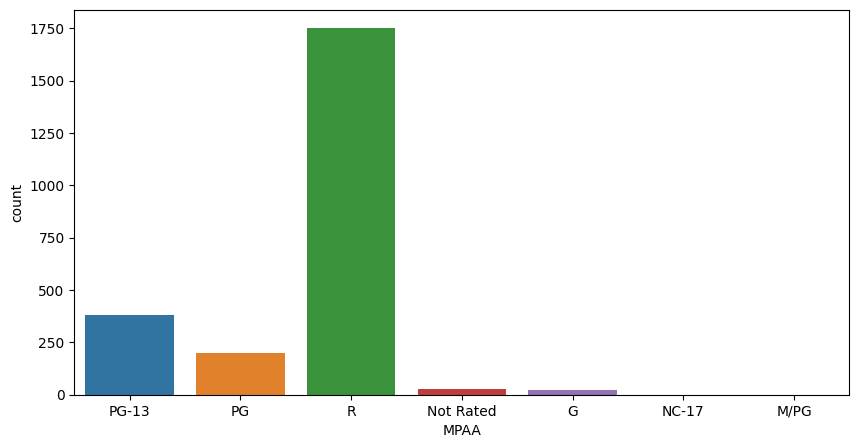

In [13]:
plt.figure(figsize=(10, 5))
sb.countplot(data=df, x='MPAA')
plt.show()

- Next, we'll take a look at the average world revenue generated by films of different MPAA ratings.
Here we can observe that the movies with PG or PG-13 ratings generally have their revenue higher than the other rating class.

In [14]:
df.groupby('MPAA').mean()['world_revenue']

MPAA
G            8.250636e+07
M/PG         5.113500e+05
NC-17        1.368800e+04
Not Rated    1.573863e+07
PG           1.405996e+08
PG-13        1.614599e+08
R            2.154372e+07
Name: world_revenue, dtype: float64

- plt.subplots(figsize=(15, 5)): This line creates a figure with subplots. The figsize parameter specifies the width and height of the entire figure in inches.

- features = []: This line creates a list called features containing the names of three numeric columns in the DataFrame df that you want to create distribution plots for.

- for i, col in enumerate(features):: This loop iterates through the features list using the enumerate() function. The i variable represents the index of the current feature, and col holds the name of the current column.

- plt.subplot(1, 3, i+1): This line specifies the position of the subplot within the figure grid. The arguments represent the number of rows, number of columns, and the index of the current subplot. In this case, there is only one row (1), three columns (3), and the index is calculated using i+1.

- sb.distplot(df[col]): This line uses Seaborn's distplot() function to create a distribution plot (histogram) for the current feature column col in the DataFrame df.

- sb.boxplot(df[col]): Used to create box plots

- plt.tight_layout(): This line adjusts the spacing between subplots to avoid overlap or crowding.

- plt.show(): This line displays the entire figure with the subplots.

- In summary, the code creates a single row of three subplots, each containing a distribution plot for a different numeric feature in the DataFrame

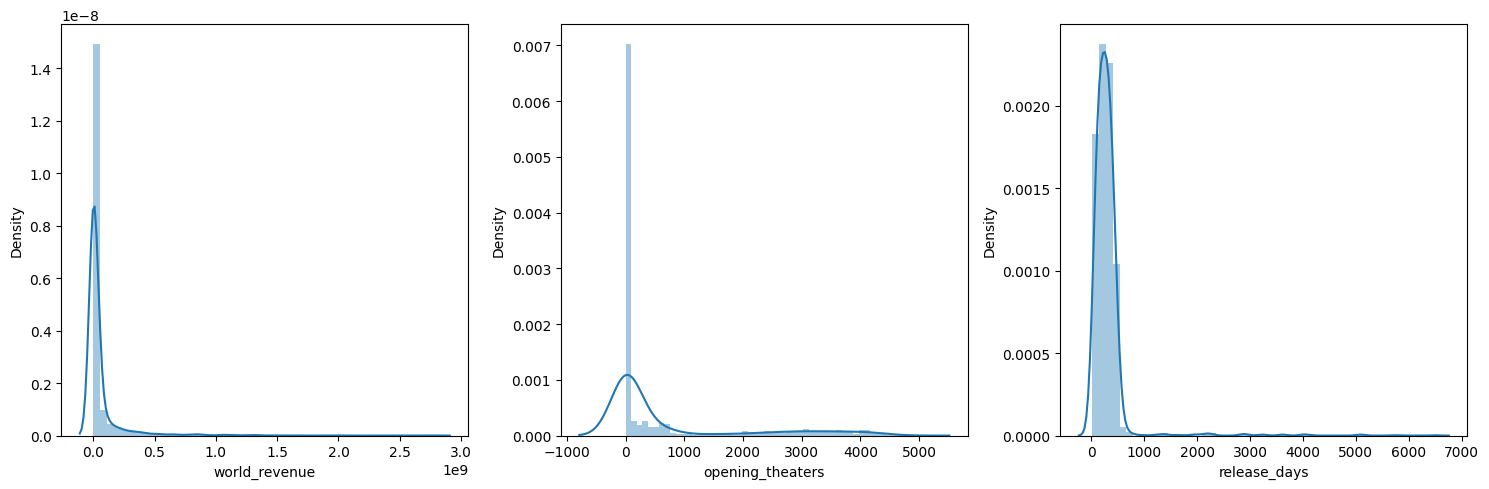

In [15]:
plt.subplots(figsize=(15,5))
features=['world_revenue','opening_theaters','release_days']
for i,col in enumerate(features):
  plt.subplot(1,3,i+1)
  sb.distplot(df[col])
plt.tight_layout()
plt.show()

These graphs show the presence of a lot of outliers

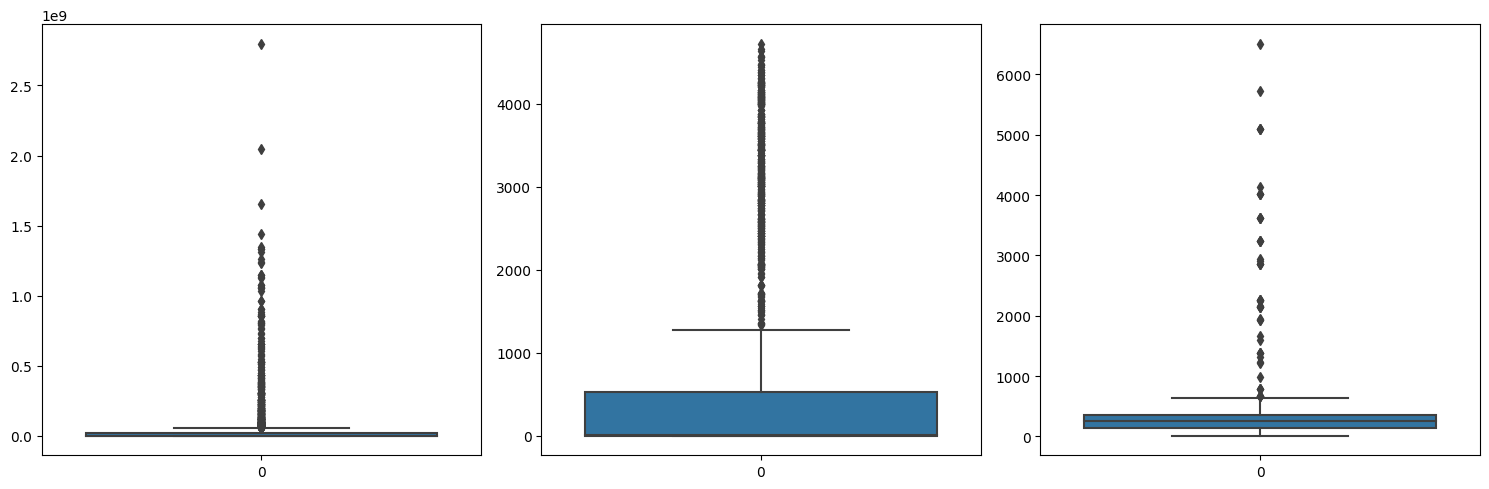

In [16]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.boxplot(df[col])
plt.tight_layout()
plt.show()

- df[col] = df[col].apply(lambda x: np.log10(x)): For each column specified by col, this line applies the following transformation to each element in the column:

- lambda x: np.log10(x): This lambda function takes an input value x and returns its base-10 logarithm using the NumPy log10() function.
df[col].apply(...): The apply() method is used to apply the specified function to each element in the column col.
- the purpose of it could be to scale the data, especially if the original values are very large

In [17]:
for col in features :
  df[col] = df[col].apply(lambda x: np.log10(x)) #the data in the columns we have visualized above should be close to normal distribution.

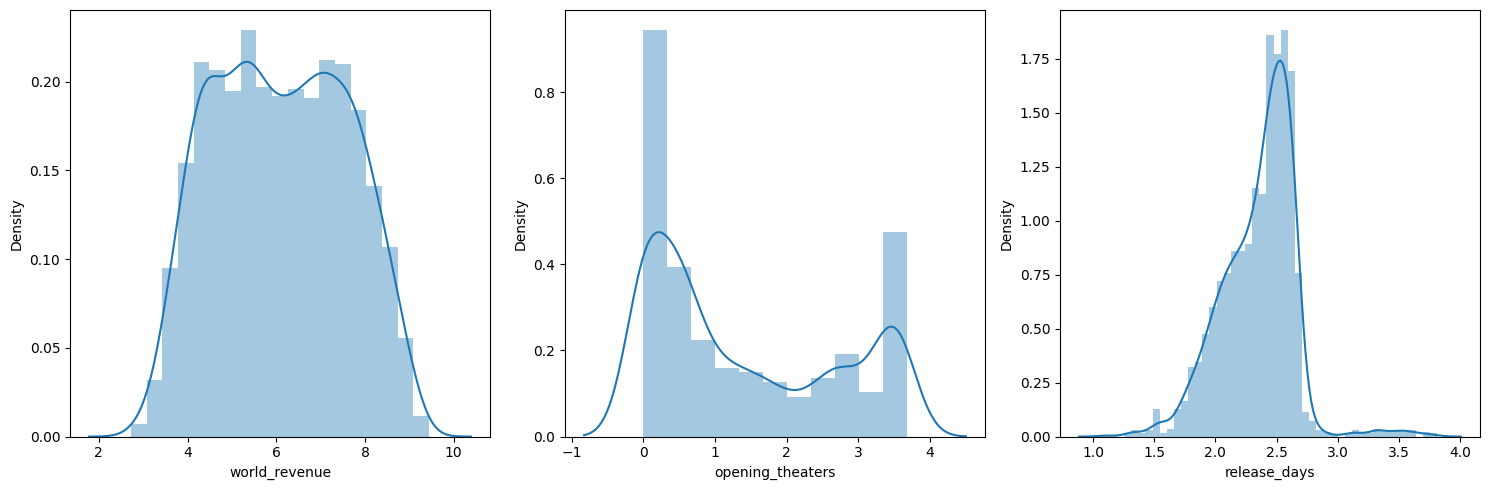

In [18]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()

- vectorizer = CountVectorizer()  initializes an instance of the countVecotrizer calss , used for tokenization and vectorization
- vectorizer.fit(df['genres']) fits vectorizer to the genres column of df. it learns vocabulary from the text data and identifies tokens (unique words)
- features = vectorizer.transform(df['genres']).toarray() : converts it to numerical format , into a sparse matrix representation that will get stored in features
- genres = vectorizer.get_feature_names_out() : this line retrieves the learned feature names from the tokenizer.
- 	df[name] = features[:, i]
: adds a new column to df. each column corresponds to a unique genre and the values in the column are the counts of how many times that genres associated words apperas in each row of genres column
- the original genres column from the df is dropped coz now its no longer needed



In [19]:
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()

genres = vectorizer.get_feature_names_out()
for i, name in enumerate(genres):
	df[name] = features[:, i]
# print(df[name])
df.drop('genres', axis=1, inplace=True)


We remove the genres that are not frequent which will lead to increase in the complexity unnecessarily. we remove collumns that have more than 95% of their values equal to 0
- 'for col in df.loc[:, 'action':'western'].columns:: This loop iterates through a subset of columns in the DataFrame df. The subset includes columns from 'action' to 'western'. This subset selection assumes that these are column labels present in the DataFrame. (these refer to the tokenised genres)

In [20]:
removed = 0
for col in df.loc[:, 'action':'western'].columns:
  if (df[col] == 0).mean() > 0.95:
    removed+=1
    df.drop(col, axis = 1, inplace = True)

print(removed)
print(df.shape)

11
(2383, 24)


Label encoder converts categorical variables into numerical variables
- in this case it is applies to columns distributor and mpaa

In [21]:
for col in ['distributor', 'MPAA']:
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])

now that all categorical variables have been label encoded, we check if there are highly correlated features
- df.corr() > 0.8: condition checks which correlation values in the correlation matrix are greater than 0.8. The result is a boolean matrix with the same shape as the correlation matrix, where True values indicate correlations above the specified threshold.
- annot = True: adds annotations to the cells
- cbar = False: removes color bar from the side of heatmap

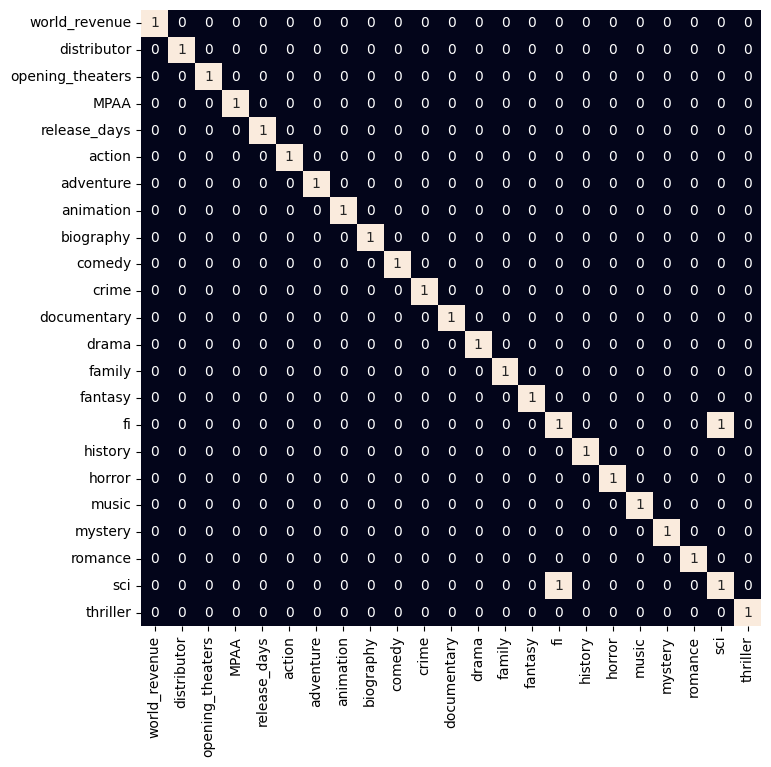

In [22]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.corr() > 0.8,
		annot=True,
		cbar=False)
plt.show()


**MODEL BULIDING**

we seperate target an features and split the variables into test and training datasets
- 10% of the data is testing and 90% if training
- random_state=22: This parameter provides a seed for the random number generator, ensuring reproducibility. Using the same random seed will result in the same data split every time the code is run.

In [28]:
features = df.drop(['title', 'world_revenue', 'fi'], axis = 1)
target = df['world_revenue'].values

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.1, random_state = 22)

X_train.shape, X_test.shape
print(features)

      distributor  opening_theaters  MPAA  release_days  action  adventure  \
0             217          3.626546     5      2.582063       1          1   
1             208          3.634477     5      2.418301       1          1   
2             218          3.619615     5      2.336460       1          1   
3             217          3.638190     5      2.382017       1          1   
4             217          3.624282     4      2.462398       0          0   
...           ...               ...   ...           ...     ...        ...   
2689          208          3.444201     6      2.829947       0          0   
2690          218          3.611511     4      2.511883       1          0   
2691          217          3.600646     4      2.607455       0          1   
2692          218          3.570543     5      2.225309       1          0   
2693          218          3.607562     5      2.612784       1          1   

      animation  biography  comedy  crime  ...  drama  family  

- standard scaler is used to standardize features by removing mean and scaling to unit variance.
- scaler.fit(X_train) calculates mean ans SD of each feature in the training set
- scaler.transform(X_train) applies the transformation to the training data.

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [26]:
train_preds = model.predict(X_train)
print('Training Error : ', mae(Y_train, train_preds))

test_preds = model.predict(X_test)
print('Validation Error : ', mae(Y_test, test_preds))
print()

Training Error :  0.1745343154142983
Validation Error :  0.5350345795327182



In [27]:
print(X_test.shape, Y_test.shape)
print(X_train.shape, Y_train.shape)

(239, 21) (239,)
(2144, 21) (2144,)


In [31]:
predicted_revenue = model.predict([[217,2.861244,5,3.656434,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
print(predicted_revenue) #Testing the model to predict, the result has to be taken as power of 10 to get exact revenue value due to the scaling done previously

[8.803798]
